<a href="https://colab.research.google.com/github/Gratisfo/Parentents-and-children/blob/main/Contrastive_analysis_RusDraCor_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка для выкачивания текстов Островского

In [1]:
import json
import requests
import csv
import pandas as pd
from tqdm import tqdm

In [2]:
# get metadata from rus corpus
r = requests.get("https://dracor.org/api/corpora/rus/metadata")

In [3]:
parsedResponse = json.loads(r.text)

In [4]:
# create list for the names of the playes
play_name = [res['name'] for res in parsedResponse]
print(len(play_name))

211


In [5]:
# create df for parent_children relation from all plays
df = pd.DataFrame(columns = ['title', 'parent', 'child'])

# list for plays' title where is relations as parent_of
parents_in_play = []

for name in play_name:
  if 'ostrovsky' in name:  
    url = "https://dracor.org/api/corpora/rus/play/{}/relations/csv".format(name)
    download = requests.get(url)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')

    for row in list(cr):
      if row[3] == 'parent_of':
        df.loc[len(df)] = [name, row[0], row[2]] # append to df title of play, parent, children
        parents_in_play.append(name)     

In [6]:
# save only unique titles
titles_play = list(set(parents_in_play))
titles_play

['ostrovsky-na-vsyakogo-mudreca-dovolno-prostoty',
 'ostrovsky-prazdnichnyj-son-do-obeda',
 'ostrovsky-groza',
 'ostrovsky-shutniki',
 'ostrovsky-ne-v-svoi-sani-ne-sadis',
 'ostrovsky-bednaja-nevesta',
 'ostrovsky-v-chuzhom-piru-pohmelje',
 'ostrovsky-goryachee-serdce',
 'ostrovsky-beshenye-dengi',
 'ostrovsky-bednost-ne-porok',
 'ostrovsky-puchina',
 'ostrovsky-ne-soshlis-harakterami',
 'ostrovsky-svoi-sobaki-gryzutsya-chuzhaya-ne-pristavaj',
 'ostrovsky-svoi-ljudi',
 'ostrovsky-staryj-drug-luchshe-novyh-dvuh',
 'ostrovsky-les',
 'ostrovsky-ne-tak-zhivi-kak-hochetsya',
 'ostrovsky-vospitannica',
 'ostrovsky-pozdnyaya-lyubov',
 'ostrovsky-semejnaya-kartina',
 'ostrovsky-bespridannitsa',
 'ostrovsky-bogatye-nevesty',
 'ostrovsky-za-chem-pojdesh-to-i-najdesh']

In [7]:
df

,title,parent,child
0,ostrovsky-bednaja-nevesta,anna_petrovna,marja_andreevna
1,ostrovsky-bednaja-nevesta,horkova,horkov
2,ostrovsky-bednost-ne-porok,GordejKarpych,LjubovGordeevna
3,ostrovsky-bednost-ne-porok,PelagejaEgorovna,LjubovGordeevna
4,ostrovsky-beshenye-dengi,nadezhda_antonovna,lidiya
5,ostrovsky-bespridannitsa,Ogudalova,Larisa
6,ostrovsky-bogatye-nevesty,cyplunova,cyplunov
7,ostrovsky-goryachee-serdce,kuroslepov,parasha
8,ostrovsky-groza,kabanova,kabanov
9,ostrovsky-les,vosmibratov,petr


In [8]:
class Play:
    def __init__(self):     
      self.title = "" 
      self.author = "" 
      self.date = "" 
      self.parents = "" 
      self.children = "" 
      self.texts = ""

In [9]:
def get_play(title):
  play = Play()

  # meta
  play.title = title
  play.date = [p['yearWritten'] for p in parsedResponse if p['playName'] == title][0]
  play.author = [p['firstAuthor'] for p in parsedResponse 
                                                        if p['playName'] == title][0]
  
  # parents\children characters
  play.parents = list(set(df[df['title'] == title].parent))
  play.children = list(set(df[df['title'] == title].child))

  # parent\children texts
  url = "https://dracor.org/api/corpora/rus/play/{}/spoken-text-by-character".format(title)
  req = requests.get(url)
  play.texts = json.loads(req.text)

  def text_char(name):
    for text in play.texts: 
      if text['id'] == name:
        text_char = text['text']
    return text_char

  play.parents_text = {name: text_char(name) for name in play.parents}
  play.children_text = {name: text_char(name) for name in play.children}
  return play



# Заполняем df

In [10]:
parent_text = []
children_text = []
for t in titles_play[:1]:
  play = get_play(t)  
  for i in play.parents_text:
    for repl in play.parents_text[i]:
      parent_text.append(repl)
  for name in play.children_text:
    for repl in play.children_text[name]:
      children_text.append(repl)

In [11]:
data = pd.DataFrame()
data['text'] = parent_text + children_text
data['role'] = ['parent' for i in range(len(parent_text))] + ['child' for i in range(len(children_text))] 
data

,text,role
0,Зачем ты заставляешь меня писать эти письма! П...,parent
1,Да что толку? Ведь за тебя не отдадут. У Турус...,parent
2,Да если бы польза была!,parent
3,Имеешь ли ты хоть какую-нибудь надежду?,parent
4,Помоги тебе Бог!,parent
...,...,...
368,"Понимаю. И вам, Иван Иваныч, я нужен.",child
369,И умных фраз позаимствоваться для спича...,child
370,И критику вместе написать.,child
371,"И вам, тетушка, нужен.",child


# Распределение реплик





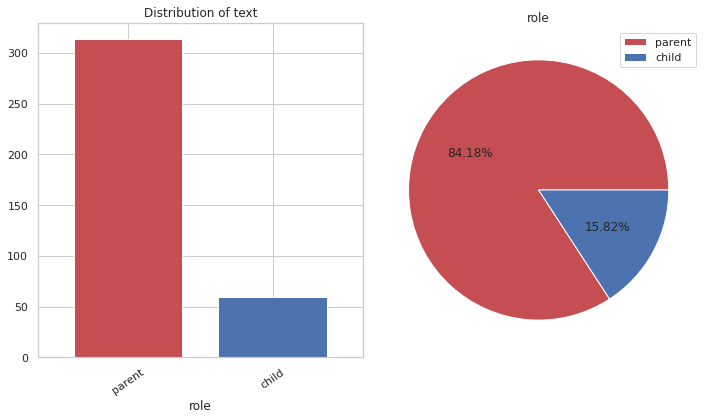

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


def plot_label_dist(df, col_name, color=["r",  "b"], kind1="bar", kind2="pie"):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    column_values = list(df[col_name].unique())

    df.groupby(col_name).size().sort_values(ascending=False).plot(
        kind=kind1, width=0.75, title="Distribution of text",
        ax=ax1, rot=35, legend=False, color=color
    )
    ax1.set_xticklabels(column_values)

    df.groupby(col_name).size().sort_values(ascending=False).plot(
        kind=kind2, title=col_name, ax=ax2, autopct="%.2f%%", labels=None, colors=color
    )
    ax2.legend(column_values)
    ax2.axis("off")

    fig.tight_layout()

plot_label_dist(df=data, col_name="role")

# Посчет токенов и предложений

In [18]:
!pip install razdel

In [20]:
from razdel import sentenize, tokenize

def get_length_sentences(text):
    segmented_sentences = sentenize(text)
    num_sentences = len(list(segmented_sentences))
    return num_sentences


def get_num_tokens(text):
    tokenized_text = tokenize(text)
    num_tokens = len(list(tokenized_text))
    return num_tokens


def get_num_sentences(text):
    segmented_sentences = sentenize(text)
    num_sentences = len(list(segmented_sentences))
    return num_sentences

In [21]:
data["sent_num"] = data["text"].apply(get_num_sentences)
data["token_num"] = data["text"].apply(get_num_tokens)

In [22]:
# вычисления стандартного отклонения, медианы, минимального, среднего и максимального значений

sent_num_subset = data["sent_num"]

print("Standard deviation: %d" % sent_num_subset.std())
print("Median: %d" % sent_num_subset.median())
print("Min value: %d" % sent_num_subset.min())
print("Mean value: %d" % sent_num_subset.mean())
print("Max value: %d" % sent_num_subset.max())

Standard deviation: 3
Median: 1
Min value: 1
Mean value: 2
Max value: 50


In [23]:
def get_length_sentences(text):
    segmented_sentences = sentenize(text)
    sent_length = []
    for s in list(segmented_sentences):
      sent_length.append(len(list(tokenize(s.text))))
    return sent_length

data["sent_len"] = data["text"].apply(get_length_sentences)

# Распределение длин предложений родителей и детей

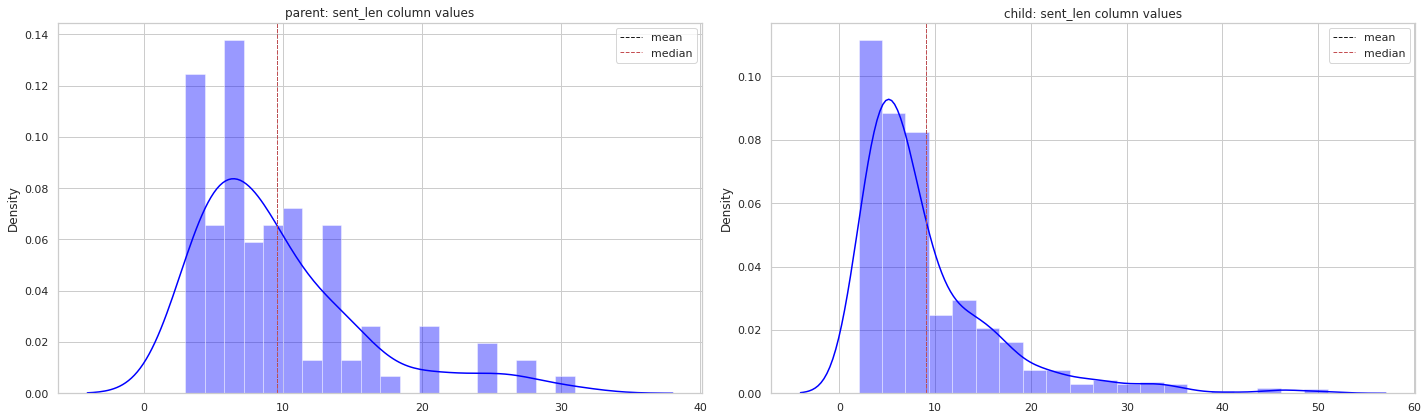

In [24]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


def plot_len_dist(data, col_name):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    for i, role in enumerate(['parent', 'child']):
      subset = []
      role_subset = data[data["role"] == role][col_name]
      for r in role_subset:
        subset = subset + r

      sns.distplot(subset, bins=20, color="blue", ax=axes[i])
      axes[i].axvline(
          sum(subset) / len(subset), color="k", linestyle="dashed", linewidth=1, label="mean"
      )
      axes[i].axvline(
          sum(subset) / len(subset), color="r", linestyle="dashed", linewidth=1, label="median"
      )
      axes[i].legend()
      axes[i].set(title="%s: %s column values" % (role, col_name))
    
    fig.tight_layout()

plot_len_dist(data, "sent_len")

In [25]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


def plot_dist(df, col_name):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    for i, role in enumerate(['parent', 'child']):
        role_subset = df[df["role"] == role][col_name]

        sns.distplot(role_subset, bins=20, color="blue", ax=axes[i])
        axes[i].axvline(
            (role_subset).mean(), color="k", linestyle="dashed", linewidth=1, label="mean"
        )
        axes[i].axvline(
            (role_subset).median(), color="r", linestyle="dashed", linewidth=1, label="median"
        )
        axes[i].legend()
        axes[i].set(title="%s: %s column values" % (role, col_name))
    
    fig.tight_layout()

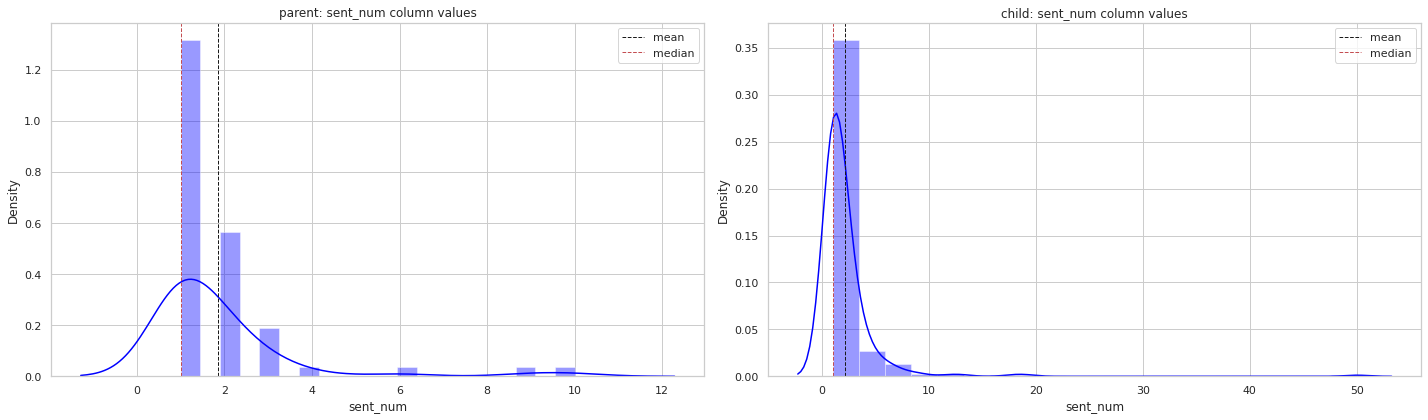

In [26]:
plot_dist(data, "sent_num")

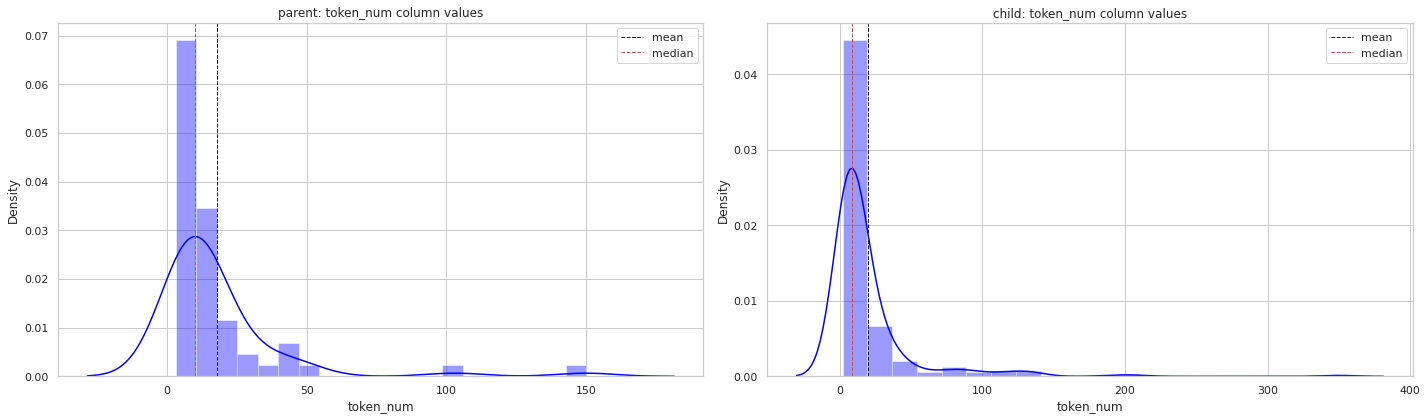

In [27]:
plot_dist(data, "token_num")

#Глубина синтаксического дерева

In [ ]:
!pip install --quiet slovnet ipymarkup
!pip install ufal.udpipe
!pip install --upgrade git+https://github.com/udapi/udapi-python.git

In [ ]:
!wget -c https://storage.yandexcloud.net/natasha-slovnet/packs/slovnet_syntax_news_v1.tar
!wget -c https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

In [30]:
from ipymarkup import show_dep_ascii_markup as show_markup
from navec import Navec
from slovnet import Syntax


navec = Navec.load("navec_news_v1_1B_250K_300d_100q.tar")
syntax = Syntax.load("slovnet_syntax_news_v1.tar")
syntax.navec(navec)


def split_into_chunks(text):
    chunks = [
        [token.text for token in tokenize(sentence.text)] for sentence in sentenize(text)
    ]
    return chunks


def annotate_text(text, syntax=syntax):
    chunks = split_into_chunks(text)
    annotation = [syntax(chunk) for chunk in chunks]
    return annotation

In [31]:
annotated_example = annotate_text(data['text'][1])
annotated_example[0]

SyntaxMarkup(
    tokens=[SyntaxToken(
         id='1',
         text='Да',
         head_id='2',
         rel='cc'
     ), SyntaxToken(
         id='2',
         text='что',
         head_id='3',
         rel='nsubj'
     ), SyntaxToken(
         id='3',
         text='толку',
         head_id='3',
         rel='advmod'
     ), SyntaxToken(
         id='4',
         text='?',
         head_id='2',
         rel='punct'
     )]
)

In [32]:
def convert_text_to_conllu(text, syntax=syntax):
    text_annotation = annotate_text(text, syntax=syntax)
    converted_sentences = []

    for annotated_text in text_annotation:
        converted_sentence = []
        for token in annotated_text.tokens:
            conllu_token = "\t".join(
            [
                token.id, # id токена в предложении
                token.text, # словоформа
                "_", # лемма
                "_", # частеречный тег
                "_", # xpos – Language-specific part-of-speech tag.
                "_", # morphosyntactic description
                token.head_id, # head of the current word
                token.rel, # dependency relation
                "_", # deps – Enhanced dependency graph in the form of a list of head-deprel pairs.
                "_", # misc – any other annotation
            ]
            )
            converted_sentence.append(conllu_token)
        converted_sentences.append("\n".join(converted_sentence))
    return converted_sentences


In [34]:
print(convert_text_to_conllu(data['text'][1])[1])

1	Ведь	_	_	_	_	5	advmod	_	_
2	за	_	_	_	_	3	case	_	_
3	тебя	_	_	_	_	5	obl	_	_
4	не	_	_	_	_	5	advmod	_	_
5	отдадут	_	_	_	_	0	root	_	_
6	.	_	_	_	_	5	punct	_	_


In [35]:
from udapi.block.read.conllu import Conllu
from udapi.block.write.textmodetrees import TextModeTrees
from io import StringIO


tree = Conllu(filehandle=StringIO(convert_text_to_conllu(data['text'][1])[1])).read_tree()

writer = TextModeTrees(attributes="ord,form,lemma,upos,feats,deprel,parent")
writer.process_tree(tree)

# sent_id = ?
# text = Ведь за тебя не отдадут .
─┮
 │ ╭─╼ 1 Ведь _ _ _ advmod <?#5, отдадут>
 │ │ ╭─╼ 2 за _ _ _ case <?#3, тебя>
 │ ┢─┶ 3 тебя _ _ _ obl <?#5, отдадут>
 │ ┢─╼ 4 не _ _ _ advmod <?#5, отдадут>
 ╰─┾ 5 отдадут _ _ _ root <?, <ROOT>>
   ╰─╼ 6 . _ _ _ punct <?#5, отдадут>



In [36]:
def tree_depth(tree):
    depth = 0
    stack = [tree]
    while (len(stack)):
        curr_node = stack[0]
        stack.pop(0)
        if curr_node.children:
            depth += 1
        for node in range(len(curr_node.children) -1, -1, -1):
            stack.insert(0, curr_node.children[node])
    return depth

In [37]:
print("Tree depth of the sentence: %s" % tree_depth(tree))

Tree depth of the sentence: 3


In [ ]:
from tqdm.auto import tqdm


def get_text(tree):
    return " ".join([node.form for node in tree.descendants])


def convert_text_to_depth_features(text):
    res = []
    converted_sentences = convert_text_to_conllu(text)
    for converted_sentence in converted_sentences:
        try:
            curr_sent_tree = Conllu(filehandle=StringIO(converted_sentence)).read_tree()
            curr_sent_depth = tree_depth(curr_sent_tree)
            res.append(
                (get_text(curr_sent_tree), curr_sent_depth, len(curr_sent_tree.descendants)-1)
            )
        except Exception as e:
            continue
    return res

results = []
depth_data = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    text = row["text"]
    depth_features = convert_text_to_depth_features(text)
    depth_data.extend(depth_features)
    results.append(depth_features)

In [39]:
syn_depth = []
for res in results:
  depth = [r[1] for r in res]
  syn_depth.append(depth)

In [40]:
 data['synt_depth'] = syn_depth

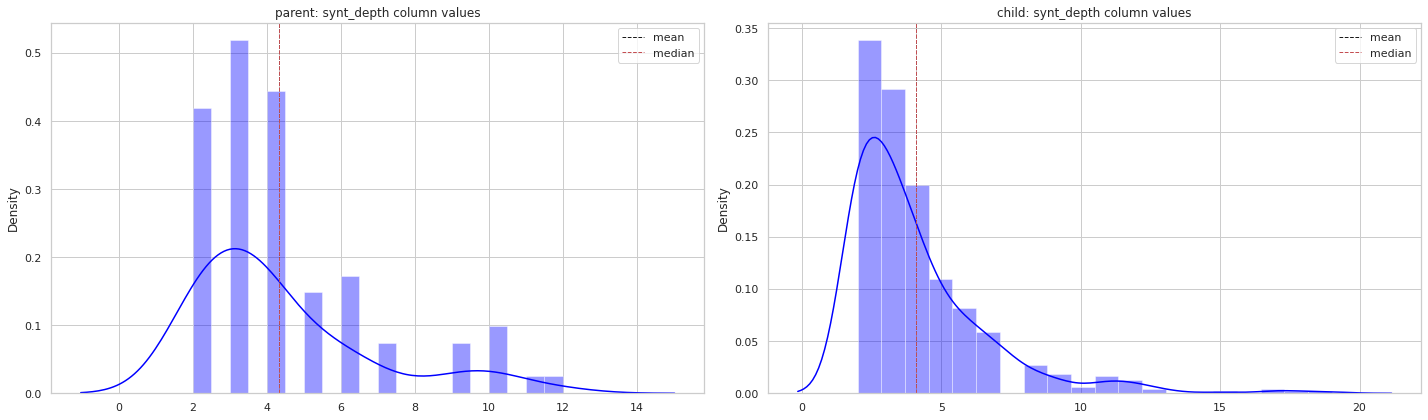

In [41]:
 # Посмотрим на распредление глубины синтаксических деревьев родителей и детей
 plot_len_dist(data, 'synt_depth')

# Препроцессинг

In [ ]:
!pip install pymorphy2[fast]

In [43]:
import re
import pymorphy2
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [45]:
def preproc_text(text):
    # токенизируем
    tokens = [_.text for _ in list(tokenize(text))]
    
    # приводим к нижнему регистру
    tokens = [w.lower() for w in tokens]
    
    # убираем пунктуацию
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # убираем числа и оставлем только кирилицу
    words = [word for word in stripped if word.isalpha()]
    
    # удаляем стоп-слова
    stop_words = set(stopwords.words('russian'))
    words = [w for w in words if not w in stop_words]
    text = " ".join(words)
  
    # приводим к начальной форме
    lemmas = [morph.parse(w)[0].normal_form for w in words] 
    pos = [morph.parse(w)[0].tag.POS for w in words]
    return text, lemmas, pos

In [49]:
lemmas = []
poses = []
prep_text = []
for i, row in tqdm(data.iterrows()):
  text, lemm, pos = preproc_text(row['text'])
  lemmas.append(lemm)
  poses.append(pos)
  prep_text.append(text)

In [50]:
data['lemmas'] = lemmas
data['speech_parts'] = poses
data['prep_text'] = prep_text

In [51]:
def build_pos_dict(corpus):
    text = ' '.join(corpus)
    text, lemmas, pos = preproc_text(text)
    pos_dict = {}
    for i in pos:
        if i in pos_dict:
            pos_dict[i] += 1
        else:
            pos_dict[i] = 1
    return dict(sorted(pos_dict.items(), key=lambda kv: kv[1], reverse=True))

# Распределение частеричных тегов

In [169]:
parent_corp = list(data[data['role']==1].text)
dict_p = build_pos_dict(parent_corp)

children_corp = list(data[data['role']==0].text)
dict_c = build_pos_dict(children_corp)

print(dict_c)
print(dict_p)

{'NOUN': 889, 'VERB': 599, 'ADJF': 388, 'INFN': 184, 'ADVB': 174, 'ADJS': 84, 'PRCL': 62, 'NPRO': 43, 'CONJ': 37, 'PRTS': 23, 'PRED': 21, 'COMP': 17, 'PREP': 11, 'NUMR': 11, 'INTJ': 6, 'GRND': 3, None: 2, 'PRTF': 2}
{'NOUN': 141, 'VERB': 105, 'ADJF': 53, 'ADVB': 22, 'INFN': 20, 'ADJS': 20, 'NPRO': 9, 'CONJ': 8, 'PRCL': 7, 'NUMR': 3, 'PRTS': 3, 'PREP': 3, 'INTJ': 2, 'PRED': 2, None: 1, 'COMP': 1}


In [ ]:
for i, e in zip(pos['pos'], pos1['pos']):
  print(i, e)

In [151]:
pos = pd.DataFrame(columns = list(dict_p.keys()))
pos.loc[0] = list(dict_p.values())
pos.loc[1] = list(dict_c.values())
pos['role'] = ['parent', 'children']

In [ ]:
plot_dist(pos, "sent_num")

In [157]:
pos

,NOUN,VERB,ADJF,ADVB,INFN,ADJS,NPRO,CONJ,PRCL,NUMR,PRTS,PREP,INTJ,PRED,NaN,COMP
0,141,105,53,22,20,20,9,8,7,3,3,3,2,2,1,1


# Классификация текстов

In [55]:
def change(x):
  if x =='parent':
    return 1
  else:
    return 0
data['role'] = data['role'].apply(change) 

## Попробуем на необработаных текстах

In [64]:
from sklearn.model_selection import train_test_split

text_train, text_test, y_train, y_test = train_test_split(data['text'], data['role'], test_size=0.25, random_state=42)

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(text_train) 
X_train_counts.shape

(279, 1629)

In [66]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(279, 1629)

### MultinomialNB

In [67]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [68]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])
text_clf = text_clf.fit(text_train, y_train)

In [69]:
from sklearn.metrics import *
predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8085106382978723


In [70]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(text_train, y_train)
gs_clf.best_score_
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [73]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB(alpha=0.01))])
text_clf = text_clf.fit(text_train, y_train)
predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8404255319148937


### SGDClassifier

In [74]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,n_iter_no_change=5, random_state=42))])

_ = text_clf_svm.fit(text_train, y_train)

predicted_svm = text_clf_svm.predict(text_test)
accuracy_score(predicted_svm, y_test)

0.8297872340425532

In [75]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(text_train, y_train)
gs_clf_svm.best_score_
gs_clf_svm.best_params_

{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [79]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(alpha=0.001))])

_ = text_clf_svm.fit(text_train, y_train)

predicted_svm = text_clf_svm.predict(text_test)
accuracy_score(predicted_svm, y_test)

0.8191489361702128

### LogisticRegression

In [80]:
from sklearn.linear_model import LogisticRegression
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression())])
text_clf = text_clf.fit(text_train, y_train)

predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8085106382978723


In [81]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__max_iter': (100, 1000)}

gs_clf_svm = GridSearchCV(text_clf, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(text_train, y_train)
gs_clf_svm.best_score_
gs_clf_svm.best_params_

{'clf__max_iter': 100, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [82]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression(max_iter=100))])
text_clf = text_clf.fit(text_train, y_train)

predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8085106382978723


### KNeighborsClassifier

In [83]:
from sklearn.neighbors import KNeighborsClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('clf', KNeighborsClassifier())])
text_clf = text_clf.fit(text_train, y_train)

predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8297872340425532


In [89]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__n_neighbors': [3,5,1,19],
               'clf__weights': ['uniform', 'distance'],
               'clf__metric': ['euclidean', 'manhattan']}

gs_clf = GridSearchCV(text_clf, parameters_svm, n_jobs=-1)
gs_clf = gs_clf.fit(text_train, y_train)
gs_clf.best_score_
gs_clf.best_params_

{'clf__metric': 'euclidean',
 'clf__n_neighbors': 3,
 'clf__weights': 'uniform',
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 1)}

In [90]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf= False)),
                      ('clf', KNeighborsClassifier(metric = 'euclidean', n_neighbors=3, weights='uniform'))])
text_clf = text_clf.fit(text_train, y_train)

predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.7978723404255319


## Попробуем на обработаных текстах

In [91]:
from sklearn.model_selection import train_test_split

text_train, text_test, y_train, y_test = train_test_split(data['prep_text'], data['role'], test_size=0.25, random_state=42)

In [92]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(text_train) 
X_train_counts.shape

(279, 1517)

In [93]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(279, 1517)

### MultinomialNB

In [101]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [102]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])
text_clf = text_clf.fit(text_train, y_train)

In [103]:
from sklearn.metrics import *
predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8085106382978723


In [105]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(text_train, y_train)
gs_clf.best_score_
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [98]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB(alpha=0.01))])
text_clf = text_clf.fit(text_train, y_train)
predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8191489361702128


### SGDClassifier

In [106]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,n_iter_no_change=5, random_state=42))])

_ = text_clf_svm.fit(text_train, y_train)

predicted_svm = text_clf_svm.predict(text_test)
accuracy_score(predicted_svm, y_test)

0.7978723404255319

### LogisticRegression

In [109]:
from sklearn.linear_model import LogisticRegression
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('clf', LogisticRegression())])
text_clf = text_clf.fit(text_train, y_train)

predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8085106382978723


### KNeighborsClassifier

In [112]:
from sklearn.neighbors import KNeighborsClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('clf', KNeighborsClassifier())])
text_clf = text_clf.fit(text_train, y_train)

predicted = text_clf.predict(text_test)
print(accuracy_score(y_test, predicted))

0.8085106382978723
